In [29]:
# default_exp datasets_challenge

In [7]:
#export
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import os
import csv

from andi_datasets.utils_challenge import segs_inside_fov, continuous_label_to_list, extract_ensemble, label_filter
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.datasets_theory import datasets_theory
from andi_datasets.utils_trajectories import normalize
from andi_datasets.utils_videos import transform_to_video

In [2]:
%load_ext autoreload
%autoreload 2

# ANDI challenge 2020

In [35]:
#export

def challenge_2020_dataset(N = 1000, max_T = 1000, min_T = 10,
                           tasks = [1, 2, 3],
                           dimensions = [1, 2, 3],
                           load_dataset = False, save_dataset = False, path_datasets = '', load_labels = True,
                           load_trajectories = False, save_trajectories = False, path_trajectories = 'datasets/',
                           N_save = 1000, t_save = 1000,
                           return_noise = False):  
    ''' Creates a dataset similar to the one given by in the ANDI challenge. 
    Check the webpage of the challenge for more details. The default values
    are similar to the ones used to generate the available dataset.
    Arguments:  
        :N (int, numpy.array):
            - if int, number of trajectories per class (i.e. exponent and model) in the dataset.
            - if numpy.array, number of trajectories per classes: size (number of models)x(number of classes)    
        :max_T (int):
            - Maximum length of the trajectories in the dataset.
        :min_T (int):
            - Minimum length of the trajectories in the dataset.
        :tasks (int, array):
            - Task(s) of the ANDI for which datasets will be generated. Task 1 corresponds to the
            anomalous exponent estimation, Task 2 to the model prediction and Task 3 to the segmen-
            tation problem.
        :dimensions (int, array):
            - Task(s) for which trajectories will be generated. Three possible values: 1, 2 and 3.
        :load_dataset (bool):
            - if True, the module loads the trajectories from the files task1.txt, task2.txt and
            task3.txt and the labels from ref1.txt, ref2.txt and ref3.txt. If the trajectories do
            not exist but the file does, the module returns and empty dataset.                
        :save_dataset (bool):
            - if True, the module saves the datasets in a .txt following the format discussed in the 
            webpage of the comptetion.
        :path_datasets (str):
            - path from where to load the dataset.
        :load_labels (bool):
            - If False, only loads trajectories and avoids the files refX.txt.
        :load_trajectories (bool):
            - if True, the module loads the trajectories of an .h5 file.  
        :save_trajectories (bool):
            - if True, the module saves a .h5 file for each model considered, with N_save trajectories 
              and T = T_save.
        :path_trajectories (str):
            - path from where to load trajectories.
        :N_save (int):
            - Number of trajectories to save for each exponents/model. Advise: save at the beggining
              a big dataset (i.e. with default t_save N_save) which allows you to load any other combiantion
              of T and N.
        :t_save (int):
            - Length of the trajectories to be saved. See comments on N_save.   
        :return_noise (bool):
            - If True, returns the amplitudes of the noises added to the trajectories.
    Return:
        The function returns 6 variables, three variables for the trajectories and three 
        for the corresponding labels. Each variable is a list of three lists. Each of the
        three lists corresponds to a given dimension, in ascending order. If one of the
        tasks/dimensions was not calculated, the given list will be empty
        :Xn (list of three lists):
            - Trajectories corresponding to Task n (with n = 1,2,3). 
        :Yn (list of three lists):
            - Labels corresponding to Task n                
        :loc_noise_tn (list of three lists):
            - if return_noise = True, collects the amplitude of the localization noise for task n.
        :diff_noise_tn (list of three lists):
            - if return_noise = True, collects the amplitude of the diffusion noise for task n. 
        The two previous variables are currently NOT SAVED NOR LOADED internally!
            '''

    print(f'Creating a dataset for task(s) {tasks} and dimension(s) {dimensions}.')

    # Checking inputs for errors
    if isinstance(dimensions, int) or isinstance(dimensions, float):
        dimensions = [dimensions]
    if isinstance(tasks, int) or isinstance(tasks, float):
        tasks = [tasks]

    # Define return datasets
    X1 = [[],[],[]]; X2 = [[],[],[]]; X3 = [[],[],[]]
    Y1 = [[],[],[]]; Y2 = [[],[],[]]; Y3 = [[],[],[]]

    if return_noise:
        loc_noise_t1 = [[],[],[]]; loc_noise_t2 = [[],[],[]]; loc_noise_t3 = [[],[],[]]
        diff_noise_t1 = [[],[],[]]; diff_noise_t2 = [[],[],[]]; diff_noise_t3 = [[],[],[]]

    if load_dataset or save_dataset:
        # Define name of result files, if needed
        task1 = path_datasets+'task1.txt'; ref1 = path_datasets+'ref1.txt'
        task2 = path_datasets+'task2.txt'; ref2 = path_datasets+'ref2.txt'
        task3 = path_datasets+'task3.txt'; ref3 = path_datasets+'ref3.txt'

    # Loading the datasets if chosen.
    if load_dataset:            
        for idx, (task, lab) in enumerate(zip([task1, task2, task3], [ref1, ref2, ref3])):
            if idx+1 in tasks:

                try:
                    t = csv.reader(open(task,'r'), delimiter=';', 
                                    lineterminator='\n',quoting=csv.QUOTE_NONNUMERIC)
                    if load_labels:
                        l = csv.reader(open(lab,'r'), delimiter=';', 
                                        lineterminator='\n',quoting=csv.QUOTE_NONNUMERIC)
                except:
                    raise FileNotFoundError(f'File for task {idx+1} not found.')


                if load_labels:                    
                    for trajs, labels in zip(t, l):   
                        if task == task1:                            
                            X1[int(trajs[0])-1].append(trajs[1:])
                            Y1[int(trajs[0])-1].append(labels[1])
                        if task == task2:
                            X2[int(trajs[0])-1].append(trajs[1:])
                            Y2[int(trajs[0])-1].append(labels[1])
                        if task == task3:
                            X3[int(trajs[0])-1].append(trajs[1:])
                            Y3[int(trajs[0])-1].append(labels[1:]) 
                else:
                    for trajs in t:   
                        if task == task1:                            
                            X1[int(trajs[0])-1].append(trajs[1:])
                        if task == task2:
                            X2[int(trajs[0])-1].append(trajs[1:])
                        if task == task3:
                            X3[int(trajs[0])-1].append(trajs[1:])

                # Checking that the dataset exists in the files
                for dim in dimensions:
                    if task == task1 and X1[dim-1] == []:
                        raise FileNotFoundError('Dataset for dimension '+str(dim)+' not contained in file task1.txt.')
                    if task == task2 and X2[dim-1] == []:
                        raise FileNotFoundError('Dataset for dimension '+str(dim)+' not contained in file task2.txt.')
                    if task == task3 and X3[dim-1] == []:
                        raise FileNotFoundError('Dataset for dimension '+str(dim)+' not contained in file task3.txt.')
        if load_labels:
            return X1, Y1, X2, Y2, X3, Y3        
        else: 
            return X1, X2, X3     


    exponents = np.arange(0.05, 2.01, 0.05)
    n_exp = len(exponents)
    # Trajectories per model and exponent. Arbitrarely chosen to obtain balanced classes
    n_per_model = np.ceil(1.6*N/5)
    subdif, superdif = n_exp//2, n_exp//2+1
    n_per_class =  np.zeros((len(datasets_theory().avail_models_name), n_exp))
    # ctrw, attm
    n_per_class[:2, :subdif] = np.ceil(n_per_model/subdif)
    # fbm
    n_per_class[2, :] = np.ceil(n_per_model/(n_exp-1))
    n_per_class[2, exponents == 2] = 0 # FBM can't be ballistic
    # lw
    n_per_class[3, subdif:] = np.ceil((n_per_model/superdif)*0.8)
    # sbm
    n_per_class[4, :] = np.ceil(n_per_model/n_exp)

    # Define return datasets
    X1 = [[],[],[]]; X2 = [[],[],[]]; X3 = [[],[],[]]
    Y1 = [[],[],[]]; Y2 = [[],[],[]]; Y3 = [[],[],[]]  

    # Initialize the files
    if save_dataset:
        if 1 in tasks:
            csv.writer(open(task1,'w'), delimiter=';', lineterminator='\n',)
            csv.writer(open(ref1,'w'), delimiter=';', lineterminator='\n',)
        elif 2 in tasks:
            csv.writer(open(task2,'w'), delimiter=';', lineterminator='\n',)
            csv.writer(open(ref2,'w'), delimiter=';',lineterminator='\n',)
        elif 3 in tasks:
            csv.writer(open(task3,'w'), delimiter=';', lineterminator='\n',)
            csv.writer(open(ref3,'w'), delimiter=';',lineterminator='\n',)

    for dim in dimensions:             
        # Generate the dataset of the given dimension
        print(f'Generating dataset for dimension {dim}.')
        dataset = datasets_theory().create_dataset(T = max_T, N_models = n_per_class, exponents = exponents, 
                                       dimension = dim, models = np.arange(len(datasets_theory().avail_models_name)),
                                       load_trajectories = False, save_trajectories = False, N_save = 100,
                                       path = path_trajectories)            

        # Normalize trajectories
        n_traj = dataset.shape[0]
        norm_trajs = normalize(dataset[:, 2:].reshape(n_traj*dim, max_T))
        dataset[:, 2:] = norm_trajs.reshape(dataset[:, 2:].shape)

        # Save unnoisy dataset for task3
        dataset_t3 = dataset.copy()

        # Add localization error, Gaussian noise with sigma = [0.1, 0.5, 1]                
        loc_error_amplitude = np.random.choice(np.array([0.1, 0.5, 1]), size = n_traj).repeat(dim)
        loc_error = (np.random.randn(n_traj*dim, int(max_T)).transpose()*loc_error_amplitude).transpose()                        
        dataset = datasets_theory().create_noisy_localization_dataset(dataset, dimension = dim, T = max_T, noise_func = loc_error)


        # Add random diffusion coefficients            
        trajs = dataset[:, 2:].reshape(n_traj*dim, max_T)
        displacements = trajs[:, 1:] - trajs[:, :-1]
        # Get new diffusion coefficients and displacements
        diffusion_coefficients = np.random.randn(n_traj).repeat(dim)
        new_displacements = (displacements.transpose()*diffusion_coefficients).transpose()  
        # Generate new trajectories and add to dataset
        new_trajs = np.cumsum(new_displacements, axis = 1)
        new_trajs = np.concatenate((np.zeros((new_trajs.shape[0], 1)), new_trajs), axis = 1)
        dataset[:, 2:] = new_trajs.reshape(dataset[:, 2:].shape)



        # Task 1 - Anomalous exponent
        if 1 in tasks:         
            # Creating semi-balanced datasets
            n_exp_max = int(np.ceil(1.1*N/n_exp))
            for exponent in exponents:
                dataset_exp = dataset[dataset[:, 1] == exponent].copy()
                dataset_exp = dataset_exp[:n_exp_max, :]
                try:
                    dataset_1 = np.concatenate((dataset_1, dataset_exp), axis = 0) 
                except:
                    dataset_1 = dataset_exp

            # Shuffle trajectories and noise                
            p = np.random.permutation(dataset_1.shape[0])                
            diffusion_coefficients_t1 = diffusion_coefficients[p].copy()
            loc_error_amplitude_t1 = loc_error_amplitude[p].copy()
            dataset_1 = dataset_1[p]

            # Saving noise with correct number of elements
            if return_noise:
                loc_noise_t1[dim-1] = loc_error_amplitude_t1[:N]
                diff_noise_t1[dim-1] = diffusion_coefficients_t1[:N]

            for traj in dataset_1[:N, :]:             
                # Cutting trajectories
                cut_T = np.random.randint(min_T, max_T) 
                traj_cut = datasets_theory()._cut_trajectory(traj[2:], cut_T, dim=dim).tolist()                         
                # Saving dataset
                X1[dim-1].append(traj_cut)
                Y1[dim-1].append(np.around(traj[1], 2))
                if save_dataset:                        
                    datasets_theory()._save_row(np.append(dim, traj_cut), task1)
                    datasets_theory()._save_row(np.append(dim, np.around([traj[1]], 2)), ref1)

        # Task 2 - Diffusion model
        if 2 in tasks:   
            # Creating semi-balanced datasets
            # If number of traejectories N is too small, consider at least
            # one trajectory per model
            n_per_model = max(1, int(1.1*N/5))                    
            for model in range(5):
                dataset_mod = dataset[dataset[:, 0] == model].copy()
                dataset_mod = dataset_mod[:n_per_model, :]
                try:
                    dataset_2 = np.concatenate((dataset_2, dataset_mod), axis = 0) 
                except:
                    dataset_2 = dataset_mod

            # Shuffle trajectories and noise                
            p = np.random.permutation(dataset_2.shape[0])                
            diffusion_coefficients_t2 = diffusion_coefficients[p].copy()
            loc_error_amplitude_t2 = loc_error_amplitude[p].copy()
            dataset_2 = dataset_2[p]
            # Saving noise wityh correct number of elements
            if return_noise:
                loc_noise_t2[dim-1] = loc_error_amplitude_t2[:N]
                diff_noise_t2[dim-1] = diffusion_coefficients_t2[:N]

            for traj in dataset_2[:N, :]:             
                # Cutting trajectories
                cut_T = np.random.randint(min_T, max_T) 
                traj_cut = datasets_theory()._cut_trajectory(traj[2:], cut_T, dim=dim).tolist() 
                # Saving dataset   
                X2[dim-1].append(traj_cut)
                Y2[dim-1].append(np.around(traj[0], 2))    
                if save_dataset:
                    datasets_theory()._save_row(np.append(dim, traj_cut), task2)
                    datasets_theory()._save_row(np.append(dim, traj[0]), ref2)   


        # Task 3 - Segmentated trajectories
        if 3 in tasks:  
            # Create a copy of the dataset and use it to create the 
            # segmented dataset
            dataset_copy1 = dataset_t3.copy()
            dataset_copy2 = dataset_t3.copy()

            # Shuffling the hard way
            order_dataset1 = np.random.choice(np.arange(n_traj), n_traj, replace = False)        
            order_dataset2 = np.random.choice(np.arange(n_traj), n_traj, replace = False)        
            dataset_copy1 = dataset_copy1[order_dataset1] 
            dataset_copy2 = dataset_copy1[order_dataset2] 

            seg_dataset = datasets_theory().create_segmented_dataset(dataset_copy1, dataset_copy2, dimension = dim)        
            seg_dataset = np.c_[np.ones(n_traj)*dim, seg_dataset]     

            # Checking that there are no segmented trajectories with same exponent and model 
            # in each segment. First we compute the difference between labels
            diff = np.abs(seg_dataset[:, 2]-seg_dataset[:, 4]) + np.abs(seg_dataset[:, 3]-seg_dataset[:, 5])
            # Then, if there are repeated labels, we eliminate those trajectories
            while len(np.argwhere(diff == 0)) > 0: 
                seg_dataset = np.delete(seg_dataset, np.argwhere(diff == 0), axis = 0)
                # If the size of the dataset is too small, we generate new segmented trajectories
                # and add them to the dataset
                if seg_dataset.shape[0] < N:

                    # Shuffling the hard way
                    new_order_dataset1 = np.random.choice(np.arange(n_traj), n_traj, replace = False)        
                    new_order_dataset2 = np.random.choice(np.arange(n_traj), n_traj, replace = False)        
                    dataset_copy1 = dataset_copy1[new_order_dataset1] 
                    dataset_copy2 = dataset_copy1[new_order_dataset2] 

                    order_dataset1 = np.concatenate((order_dataset1, new_order_dataset1))
                    order_dataset2 = np.concatenate((order_dataset2, new_order_dataset2))

                    aux_seg_dataset = datasets_theory().create_segmented_dataset(dataset_copy1, dataset_copy2, dimension = dim) 
                    aux_seg_dataset = np.c_[np.ones(aux_seg_dataset.shape[0])*dim, aux_seg_dataset] 
                    seg_dataset = np.concatenate((seg_dataset, aux_seg_dataset), axis = 0)

                    diff = np.abs(seg_dataset[:, 2]-seg_dataset[:, 4]) + np.abs(seg_dataset[:, 3]-seg_dataset[:, 5])
                else:
                    break 

            # Add localization error, Gaussian noise with sigma = [0.1, 0.5, 1]                
            loc_error_amplitude_t3 = np.random.choice(np.array([0.1, 0.5, 1]), size = seg_dataset.shape[0]).repeat(dim)
            loc_error_t3 = (np.random.randn(seg_dataset.shape[0]*dim, 200).transpose()*loc_error_amplitude_t3).transpose()

            seg_dataset[:, 4:] = datasets_theory().create_noisy_localization_dataset(seg_dataset[:, 4:], 
                                                                        dimension = dim, T = 200, 
                                                                        noise_func = loc_error_t3)


            # Add random diffusion coefficients            
            trajs = seg_dataset[:, 6:].reshape(seg_dataset.shape[0]*dim, 200)
            displacements = trajs[:, 1:] - trajs[:, :-1]
            # Get new diffusion coefficients and displacements
            diffusion_coefficients_t3 = np.random.randn(seg_dataset.shape[0]).repeat(dim)
            new_displacements = (displacements.transpose()*diffusion_coefficients_t3).transpose()  
            # Generate new trajectories and add to dataset
            new_trajs = np.cumsum(new_displacements, axis = 1)
            new_trajs = np.concatenate((np.zeros((new_trajs.shape[0], 1)), new_trajs), axis = 1)
            seg_dataset[:, 6:] = new_trajs.reshape(seg_dataset[:, 6:].shape)

            if return_noise:
                loc_noise_t3[dim-1] = loc_error_amplitude_t3[:N].tolist()
                diff_noise_t3[dim-1] = diffusion_coefficients_t3[:N].tolist()




            X3[dim-1] = seg_dataset[:N, 6:]
            Y3[dim-1] = seg_dataset[:N, :6]

            if save_dataset:
                for label, traj in zip(seg_dataset[:N, :6], seg_dataset[:N, 6:]):
                    datasets_theory()._save_row(np.append(dim, traj), task3)
                    datasets_theory()._save_row(np.around(label, 2), ref3) 


    if return_noise:
        return [X1, Y1, loc_noise_t1, diff_noise_t1, 
                X2, Y2, loc_noise_t2, diff_noise_t2, 
                X3, Y3, loc_noise_t3, diff_noise_t3] 
    else:
        return X1, Y1, X2, Y2, X3, Y3

# ANDI challenge 2022

In [8]:
#export
class _df_andi2: 
    'This class is used to define some of the default values set for the ANDI 2022 challenge'
    def __init__(self):        
        # General parameters

        self.T = 500                   # Length of simulated trajectories
        self._min_T = 20               # Minimal length of output trajectories
        self.FOV_L = 128               # Length side of the FOV (px)
        self.L = 1.2*self.FOV_L          # Length of the simulated environment
        'PARTICLES MOVE TOO SLOWLY WITH D = 0.1!!'
        self.D = 1                     # Baseline diffusion coefficient (px^2/frame)
        self.density = 2               # Particle density   
        self.N = 50                    # Number of particle in the whole experiment
        self.sigma_noise = 0.12        # Variance of the localization noise

        self.label_filter = lambda x: label_filter(x, window_size = 5, min_seg = 3) 

In [9]:
#export
def _get_dic_andi2(model):
    ''' Given the number label of diffusion model, returns a default
    dictionary of the model's parameters to be fed to create_dataset
    The numeration is as follow:
            1: single state
            2: N-state
            3: immobilization
            4: dimerization
            5: confinement
    Args:
        :model (int in [1,6]): number of the diffusion model
    Return:
        :dic (dictionary): dictionary containing the default parameters
        for ANDI2022 of the indicated model.
    '''

    dic = {'N': _df_andi2().N,
           'T': _df_andi2().T,
           'L': _df_andi2().L}

    # alpha and D for single-state and immobilization
    if model == 1 or model == 3:    
        dic.update({'Ds': [_df_andi2().D, _df_andi2().D*0.01], # mean and varianve for D
                    'alphas': np.array([np.random.rand()*(1.5-0.5)+0.5, 0.01])})

    # alphas and Ds for 2-state, confinement and dimerization
    if model == 2 or model == 4 or model == 5:            

        fast_D = _df_andi2().D + np.random.randn()*_df_andi2().D*0.01
        slow_D = fast_D*np.random.rand()*(0.1-0.01)+0.01    

        alpha1 = np.random.rand()*(1.2-0.8)+0.8
        # The second state will be at least 0.2 afar. We make sure not being 
        # outside [0,2]        
        alpha2 = alpha1 - (np.random.rand()*(0.6-0.2)+0.2)

        dic.update({'Ds': np.array([[fast_D, 0.01],
                                    [slow_D, 0.01]]),
                    'alphas': np.array([[alpha1, 0.01],
                                        [alpha2, 0.01]])})

    # Particle/trap radius and ninding and unbinding probs for dimerization and immobilization
    if model == 3 or model == 4:
        dic.update({'Pu': 0.01,                           # Unbinding probability
                    'Pb': 1})                             # Binding probabilitiy

    if model == 1:
        dic.update({'model': datasets_phenom().avail_models_name[0]})

    if model == 2:
        dic.update({'model': datasets_phenom().avail_models_name[1],
                    'M': np.array([[0.99, 0.01],            # Transition Matrix
                                   [0.01, 0.99]]),
                    'return_state_num': True              # To get the state numeration back, , hence labels.shape = TxNx4
                   })
    if model == 3:
        dic.update({'model': datasets_phenom().avail_models_name[2],
                    'Nt': 300,            # Number of traps (density = 1 currently)
                    'r': 0.4}             # Size of trap
                  )
    if model == 4:
        dic.update({'model': datasets_phenom().avail_models_name[3],
                    'r': 0.6,                 # Size of particles
                    'return_state_num': True  # To get the state numeration back, hence labels.shape = TxNx4
                   })

    if model == 5:
        dic.update({'model': datasets_phenom().avail_models_name[4],
                    'r': 5,
                    'Nc': 30,
                    'trans': 0.1})

    return dic

## Generating function
This function generates trajectory datasets like the ones considered in the ANDI 2022 Challenge. It is based in `models_phenom.create_dataset` but also applies:

- Apply Field of View (FOV)
- Add localization noise
- Smooth labels
- Extracts ensemble properties
- Correct labeling of trajectories


**Inputs:**
- Number of experiments (one experiment = one model).

    For each experiment:
    - Number of particles
    - Number of FOVs
    - Parameters of the model
    - Mininum length of trajectories
    
**Outputs:** (this should be the same as the expected challenge inputs)
    
- For each FOV:
    - Ensemble properties (Compulsory: model, $\alpha$ and $D$ distribution)
    - Trajectory properties (list of properties: $\alpha_1$, $D_1$, CP$_1$, $\alpha_2$, $D_2$, CP$_2$,...)

In [101]:
#export

def challenge_2022_dataset( 
                          experiments = 5,
                          dics = None,
                          repeat_exp = True,
                          num_fovs = 20,
                          return_timestep_labs = False,
                          save_data = False,
                          path = 'data/',
                          prefix = '',
                          get_video = False, num_vip = None
                            ):
    ''' 
    Creates a datasets with same structure as ones given in the ANDI 2022 challenge. Default values for the
    various diffusion models have been set such as to be in the same ranges as the ones expected for the
    challenge. For details, check the ANDI 2022 challenge webpage.
    This function will generate as many experiments (associated to one the diffusion models) as demanded.
    There are two ways of defining that:
        - Give number of experiments (and optional parameters such as repeat_exp) to create. The diffusion
        parameters are then taken from the default values are taken from datasets_phenom._df_andi2.
        - Feed a list of dictionaries (dics) from which data will be generated
    For each experiment, as many field of view as wanted can be generated        

    Args:  
        :experiments (int, list): - if int: Number of experiments to generate. Each experiment is 
                                            generated from one of the available diffusion models.  
                                  - if list: diffusion models to generate
        :dics (dictionary, list of dics): if given, uses this to set the parameters of the experiments
                                          Must be of length equal to experiments. This overrides any
                                          info about chosen models, as the model is set by the dictio-
                                          nary.
        :repeat_exp (bool, list): (Does not enter into play if experiments is list)
                                  - True: picks at random the diffusion model from the pool
                                  - False: picks the diffusion in an ordered way from the pool
        :num_fovs (int): Number of field of views to get trajectories from in each experiment.
        :return_timestep_labs (bool): if True, the output trajectories dataframes containing also the 
                                      labels alpha, D and state at each time step.
        :save_data (bool): if True, saves all pertinent data.
        :path (str): path where to store the data
        :prefix (str): extra prefix that can be added in front of the files' names.

    Return:
        :trajs_out (list): list of lenght (experiments x num_fovs). Each elements are is dataframe
                           containing the trajectories of a particular experiment/fov, in order of 
                           generation (i.e. [exp1_fov1, exp1_fov2, ..., exp2_fov1 ....]).
                           If return_timestep_labs = True, the dataframes also contain the labels
                           at each time step
        :labels_traj_out (list): list of same length of trajs_out containing the labels of the 
                                 corresponding trajectories. Each element contains a list with the 
                                 labels of each trajectory, following the scheme:
                                 [idx_traj, D_1, alpha_1, state_1, CP_1, D_2, alpha_2, .... state_N]
        :labels_ens_out (list): list of same length of trajs_out containing the ensemble labels of 
                                given experiment. See description of output matrix in 
                                utils_challenge._extract_ensemble()
        '''



    # Set prefixes for saved files
    if save_data:
        if not os.path.exists(path):
            os.makedirs(path)
        pf_labs_traj = path+prefix+'traj_labs'
        pf_labs_ens = path+prefix+'ens_labs'
        pf_trajs = path+prefix+'trajs'

    if return_timestep_labs:
        df_list = []

    # Sets the models of the experiments that will be output by the function
    if dics is None:
        if isinstance(experiments, int):
            if repeat_exp: # If experiments can be repeated, we just sample randomly
                model_exp = np.random.randint(len(datasets_phenom().avail_models_name), size = experiments)
            else: # If not, we sampled them in an ordered way
                if experiments >= len(datasets_phenom().avail_models_name):
                    num_repeats = (experiments % len(datasets_phenom().avail_models_name))+1
                else:
                    num_repeats = 1
                model_exp = np.tile(np.arange(len(datasets_phenom().avail_models_name)), num_repeats)[:experiments]
            # We add one to get into non-Python numeration
            model_exp += 1
        else:
            model_exp = experiments
    # If list of dics is given, then just create a list of length = len(dics)
    else: 
        model_exp = [0]*len(dics)

    # Output lists
    trajs_out, labels_traj_out, labels_ens_out = [], [], []
    for idx_experiment, model in enumerate(tqdm(model_exp)):

        ''' Generate the trajectories '''
        if dics is None:
            dic = _get_dic_andi2(model)
        else:
            dic = dics[idx_experiment]
            # Overide the info about model
            model = datasets_phenom().avail_models_name.index(dic['model'])+1

        trajs_og, labels = datasets_phenom().create_dataset(dics = dic)     
        

        # Add noise the trajectories
        trajs = trajs_og + np.random.randn(*trajs_og.shape)*_df_andi2().sigma_noise    

        ''' Apply the FOV '''
        for fov in range(num_fovs):

            # Checking if file exist and creating an error
            if save_data:
                if os.path.exists(pf_labs_traj+f'_exp_{idx_experiment}_fov_{fov}.txt') or os.path.exists(pf_labs_ens+f'_exp_{idx_experiment}_fov_{fov}.txt'):
                    raise FileExistsError(f'Target files for experiment {idx_experiment} and FOV {fov}. Delete the file or change path/prefix.')            



            # We take as min/max for the fovs a 5 % distance of L
            dist = 0.05
            min_fov = int(dist*_df_andi2().L)
            max_fov = int((1-dist)*_df_andi2().L)-_df_andi2().FOV_L
            # sample the position of the FOV
            fov_origin = (np.random.randint(min_fov, max_fov), np.random.randint(min_fov, max_fov))

            ''' Go over trajectories in FOV (copied from utils_trajectories for efficiency) '''
            trajs_fov, array_labels_fov, list_labels_fov, idx_segs_fov, frames_fov = [], [], [], [], []
            idx_seg = -1

            # Total frames
            frames = np.arange(trajs.shape[0])
            # We save the correspondance between idx in FOV and idx in trajs dataset
            corresponance_idx = []
            for idx, (traj, label) in enumerate(zip(trajs[:, :, :].transpose(1,0,2),
                                                    labels[:, :, :].transpose(1,0,2))):
                nan_segms = segs_inside_fov(traj, 
                                            fov_origin = fov_origin,
                                            fov_length = _df_andi2().FOV_L,
                                            cutoff_length = _df_andi2()._min_T)

                if nan_segms is not None:
                    for idx_nan in nan_segms:  
                        idx_seg+= 1
                        
                        # save index correspondance
                        corresponance_idx.append([idx, idx_seg])

                        seg_x = traj[idx_nan[0]:idx_nan[1], 0]
                        seg_y = traj[idx_nan[0]:idx_nan[1], 1]


                        trajs_fov.append(np.vstack((seg_x, seg_y)).transpose())
                        frames_fov.append(frames[idx_nan[0]:idx_nan[1]])

                        lab_seg = []
                        for idx_lab in range(labels.shape[-1]):
                            lab_seg.append(_df_andi2().label_filter(label[idx_nan[0]:idx_nan[1], idx_lab]))
                        lab_seg = np.vstack(lab_seg).transpose()                    
                        array_labels_fov.append(lab_seg)

                        # Tranform continuous labels to list for correct output
                        if model == 2 or model == 4: 
                            # if multi-state or dimerization, we get rid of the label of state numbering
                            CP, alphas, Ds, states = continuous_label_to_list(lab_seg[:, :-1])
                        else:
                            CP, alphas, Ds, states = continuous_label_to_list(lab_seg)
                        
                        # Extract final point of trajectory 
                        T = CP[-1]
                        CP = CP[:-1]
                        list_gt = [idx_seg, Ds[0], alphas[0], states[0]]
                        for gtc, gta, gtd, gts in zip(CP, alphas[1:], Ds[1:], states[1:]):
                            list_gt += [gtc, gtd, gta, gts]
                        # Add end point of trajectory
                        list_gt.append(T)
                        list_labels_fov.append(list_gt)     

                        if save_data:
                            with open(pf_labs_traj+f'_exp_{idx_experiment}_fov_{fov}.txt', 'a') as f:
                                writer = csv.writer(f, delimiter=',', lineterminator='\n',)
                                writer.writerow(list_gt)

                        # Save index of segment with its length to latter append in the dataframe    
                        idx_segs_fov.append(np.ones_like(seg_x)*idx_seg)                        

            '''Extract ensemble trajectories''' 
            ensemble_fov = extract_ensemble(np.concatenate(array_labels_fov)[:, -1], dic)

            df_data = np.hstack((np.expand_dims(np.concatenate(idx_segs_fov), axis=1),
                                 np.expand_dims(np.concatenate(frames_fov), axis=1),
                                 np.concatenate(trajs_fov)))
            df_traj = pd.DataFrame(df_data, columns = ['traj_idx', 'frame', 'x', 'y']) 


            if return_timestep_labs:
                array_labels_fov = np.concatenate(array_labels_fov)
                df_traj['alpha'] = array_labels_fov[:, 0]
                df_traj['D'] = array_labels_fov[:, 1]
                df_traj['state'] = array_labels_fov[:, 2]

            if save_data:
                # Trajectories                    
                df_traj.to_csv(pf_trajs+f'_exp_{idx_experiment}_fov_{fov}.csv', index = False)
                # Ensemble labels
                with open(pf_labs_ens+f'_exp_{idx_experiment}_fov_{fov}.txt', 'a') as f:
                    if model == 2: num_states = dic['alphas'].shape[0]
                    elif model == 1: num_states = 1
                    else: num_states = 2
                    model_n = dic['model']
                    f.write(f'model: {model_n}; num_state: {num_states} \n')
                    np.savetxt(f, ensemble_fov, delimiter = ';')
            
            if get_video:
                print(f'Generating video for EXP {idx_experiment} FOV {fov}')
                corresponance_idx = np.array(corresponance_idx)
                idx_vip = corresponance_idx[np.random.randint(0, trajs.shape[1], size = num_vip), 0].tolist()
                video_fov = transform_to_video(trajs_og, # see that we insert the trajectories without noise!
                                               optics_props={
                                                   "output_region":[fov_origin[0], fov_origin[1],
                                                                    fov_origin[0] + _df_andi2().FOV_L, fov_origin[1] + _df_andi2().FOV_L]
                                                },
                                               get_vip_particles=idx_vip)
                try:
                    videos_out.append(video_fov)
                except:
                    videos_out = [video_fov]

            # Add data to main lists (trajectories and lists with labels)   
            trajs_out.append(df_traj)
            labels_traj_out.append(list_labels_fov)
            labels_ens_out.append(ensemble_fov)
    if get_video:
        return trajs_out, videos_out, labels_traj_out, labels_ens_out
    else:
        return trajs_out, labels_traj_out, labels_ens_out

In [87]:
num_experiments, num_fovs = 1, 1
df_list, videos, lab_t, lab_e = challenge_2022_dataset(experiments = num_experiments,
                                                   num_fovs = num_fovs, 
                                                   return_timestep_labs=True, 
                                                   get_video=True, num_vip= 4)

  0%|          | 0/1 [00:00<?, ?it/s]

Generating video for EXP 0 FOV 0
[0, 11, 4, 28] (500, 50, 2)
(0, 0) 128


In [88]:
df = df_list[0]; video = videos[0]

In [91]:
df

,traj_idx,frame,x,y,alpha,D,state
0,0.0,0.0,86.416702,52.310740,0.721121,1.083395,2.0
1,0.0,1.0,87.841669,51.691739,0.721121,1.083395,2.0
2,0.0,2.0,86.640341,53.729847,0.721121,1.083395,2.0
3,0.0,3.0,82.505496,50.587452,0.721121,1.083395,2.0
4,0.0,4.0,83.366036,49.505539,0.721121,1.083395,2.0
...,...,...,...,...,...,...,...
16117,48.0,495.0,76.724262,17.708839,0.748051,0.970962,2.0
16118,48.0,496.0,77.834792,18.115573,0.748051,0.970962,2.0
16119,48.0,497.0,76.499178,20.770703,0.748051,0.970962,2.0
16120,48.0,498.0,75.588961,17.996042,0.748051,0.970962,2.0


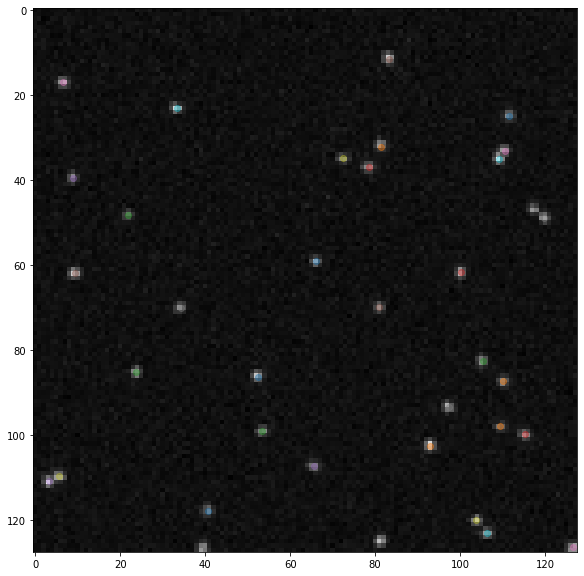

In [100]:
'''To do this plot you need to fix the FOV to (0,0) in the generating function!'''
fig, ax0 = plt.subplots(figsize=(10, 10))
img1 = ax0.imshow(video[1], cmap="gray")
for idx in np.unique(np.unique(df.traj_idx)):
    df_part = df.loc[df.traj_idx == idx]
    if df_part.frame.values[0] == 0:
        ax0.scatter(df_part.y.values[0], df_part.x.values[0], alpha = 0.4)


# NBDEV

In [102]:
from nbdev.export import notebook2script
notebook2script()

Converted analysis.ipynb.
Converted datasets_challenge.ipynb.
Converted datasets_phenom.ipynb.
Converted datasets_theory.ipynb.
Converted models_phenom.ipynb.
Converted models_theory.ipynb.
Converted utils_challenge.ipynb.
Converted utils_trajectories.ipynb.
Converted utils_videos.ipynb.
